**Computer Vision Multi-Classification Neural Network**

Ernest López Sánchez


We are going to apply a multi-classification neural network to a dataset of 26350 animal images in order to classify them by species.

There are 10 possible classes:
- Butterfly
- Cat
- Chicken
- Cow
- Dog
- Elephant
- Horse
- Sheep
- Spider
- Squirrel

First, we will explore the dataset.

Then we will transform our data as needed and compare the performance of different neural network architectures.

We are specifically going to design, tune, train and test:

-  A fully connected traditional artificial neural network.
-  A convolutional neural network with and without data augmentation.

We will also test the performance of InceptionV3 (through transfer learning), an already-trained convolutional neural network specifically designed for computer vision.

We will check how it does by itself, without any exposure to the actual data, and with expose to the actual data (fine-tuning).

Afterward, we are going to evaluate the results of our model using the typical metrics of a multi-classification problem.

Finally, we are going to try to improve the performance our first small convolutional neural network had by improving the neural network architecture.

We will use TensorFlow and the Keras functional API in order to do so. If you were interested in the specific coding behind any of the Keras layers, you can refer to the Keras documentation.

I'm using a paid GPU in Google Colab to train and test the models, but you can use the free ones given by TensorFlow-cuda.

Images are represented using RGB, so an image size will always be [height, width, 3].

In [ ]:
import tensorflow as tf
print("TF version   : ", tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.15.0


In [ ]:
# Import the desired Keras elements
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model

In [ ]:
# Import some utilities
import cv2
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools

## 1. Download, analysis and preprocessing of the data

The file used is provided in my github repository and is called images.

It has the typical structure of a computer vision dataset: train and test directories, inside which there is a folder containing the images for each class.

Let's explore our dataset.

In [ ]:
# Load the file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the classes in the train dataset
images_directory = '/content/drive/MyDrive/images'
train_classes = os.listdir(os.path.join(images_directory, 'train'))
print(f"The classes available in the train dataset are {sorted(train_classes)}")

The classes available in the train dataset are ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
# Check the classes in the test dataset
images_directory = '/content/drive/MyDrive/images'
test_classes = os.listdir(os.path.join(images_directory, 'test'))
print(f"The classes available in the test dataset are {sorted(test_classes)}")

The classes available in the test dataset are ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
# Check how many images per class the train dataset contains
def count_files(directory):
  ''' Given a directory counts the files that are inside'''
  return len([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])


images_directory = '/content/drive/MyDrive/images'
train_directory = os.path.join(images_directo
                               ry, 'train')
train_counts = {}
for class_name in sorted(os.listdir(train_directory)):
    class_path = os.path.join(train_directory, class_name)
    train_counts[class_name] = count_files(class_path)

print('The files for each class are:')
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

The files for each class are
butterfly: 1795
cat: 1418
chicken: 2633
cow: 1586
dog: 4134
elephant: 1229
horse: 2230
sheep: 1547
spider: 4098
squirrel: 1583


In [ ]:
# Check how many images per class the test dataset contains
test_directory = os.path.join(images_directory, 'test')

test_counts = {}
for class_name in sorted(os.listdir(test_directory)):
    class_path = os.path.join(test_directory, class_name)
    test_counts[class_name] = count_files(class_path)

print('The files for each class are')
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

The files for each class are
butterfly: 317
cat: 250
chicken: 465
cow: 280
dog: 729
elephant: 217
horse: 393
sheep: 273
spider: 730
squirrel: 279


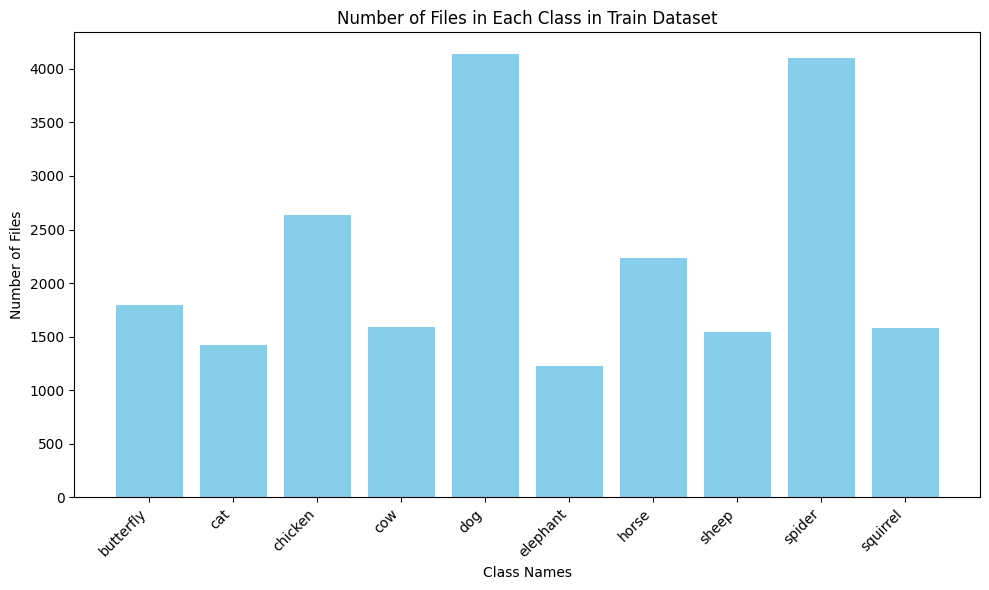

In [ ]:
# Plot the number of images for each class in the train dataset
class_names = sorted(list(train_counts.keys()))
counts = list(train_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class in Train Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

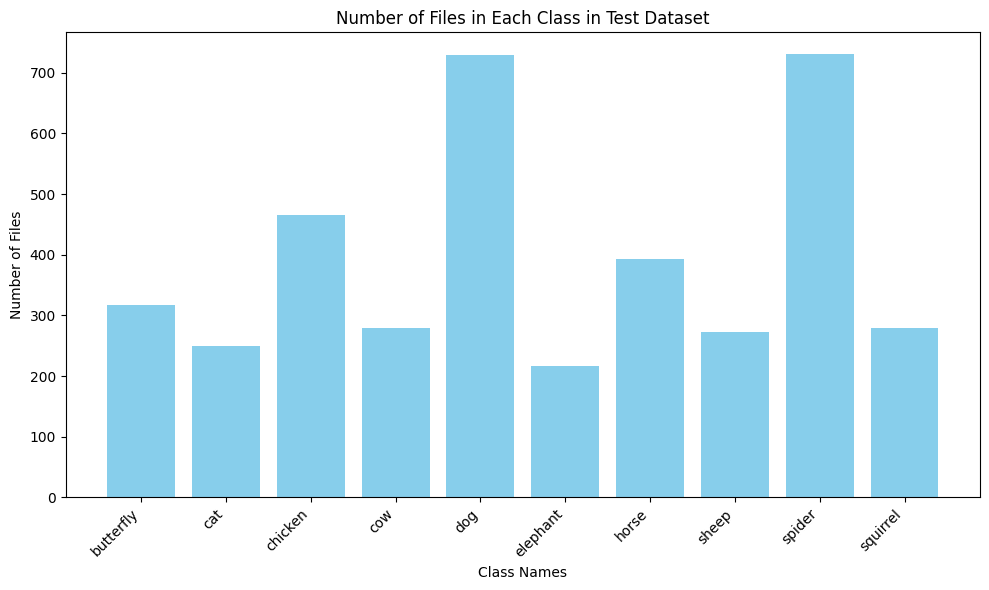

In [ ]:
# Plot the number of images for each class in the test dataset
class_names = sorted(list(test_counts.keys()))
counts = list(test_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class in Test Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The training dataset has 22.253 images, while the test dataset has 3.926. Thus, our training dataset has 85% of the data and the test has 15%.

The distribution of images for each class is exactly the same in both datasets.
As an example, 8% of all images are of class butterfly in both datasets.
We can visually check that the only thing that changes between both graphics is the scale of the y-axis.

This is done in order to prevent bias in training or testing. If this distribution of images per class was highly different in test than in training, we could find that our results are not optimal, or they can even be severely deficient because our model would have been trained with a data structure that is very different from the testing one.

Our training data should be able to provide the model with a generalization of reality; if the training data is far away from reality, then our model will not have good results.

By having the same distribution in both datasets, we make sure that our model does not underperform or overperform due to distribution issues in either of the two datasets. So we make sure he is not learning the distribution of samples per class; instead, he is learning the relationships and trends underlying our data.

### 1.2. Image visualization

Let's check some of our images.

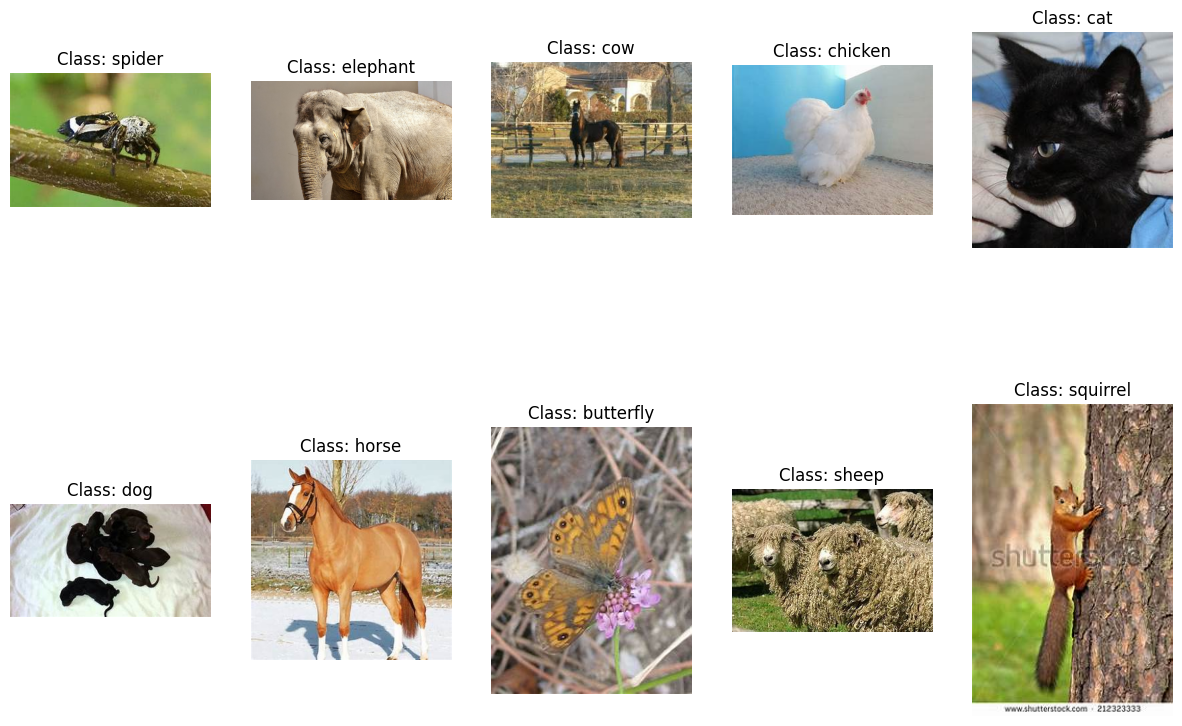

In [ ]:
# Randomly plot 10 images and its class.
import random

data_dir = '/content/drive/MyDrive/images/train'
class_dirs = os.listdir(data_dir)

plt.figure(figsize=(15, 10))
for i, class_dir in enumerate(class_dirs, start=1):
    class_path = os.path.join(data_dir, class_dir)
    images = os.listdir(class_path)

    random_image = random.choice(images)

    image_path = os.path.join(class_path, random_image)
    image = Image.open(image_path)

    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(f'Class: {class_dir}')
    plt.axis('off')

plt.show()

In [ ]:
# Let's check the dynamic range of the images in our dataset.
import os
from PIL import Image
import random
data_dir = '/content/drive/MyDrive/images/train'

min_pixel_value = float('inf')
max_pixel_value = 0

num_images_to_sample = 10

# Get 10 random images
all_image_paths = []
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    all_image_paths += [os.path.join(class_path, image_name) for image_name in os.listdir(class_path)]
random.shuffle(all_image_paths)

# Check highest and lowest possible values of a pixel of those 10 images.
for image_path in all_image_paths[:num_images_to_sample]:
    image = Image.open(image_path)
    pixels = list(image.getdata())
    min_pixel_value = min(min_pixel_value, min(min(pixel) for pixel in pixels))
    max_pixel_value = max(max_pixel_value, max(max(pixel) for pixel in pixels))

print("Minimum pixel value:", min_pixel_value)
print("Maximum pixel value:", max_pixel_value)

Minimum pixel value: 0
Maximum pixel value: 255


If we check our image plotting, we can easily see that not all images have the same size. This is a problem; we need them to have a common size in order to feed them to our neural network.

So we need to resize them to have a common format.

The dynamic range of an image is the highest and lowest possible values of a pixel.

We check 10 images due to efficiency reasons; we assume it is enough to find the lowest and highest possible values of a pixel; if this was not correct, we would find it afterward.

The dynamic range of our images goes from 0 to 255; a common characteristic of RGB representations is that the range goes from (0,0,0) (black) to (255, 255, 255) (white).

More info on RGB: https://www.w3schools.com/colors/colors_rgb.asp

### 1.3. Creation of the datasets in TensorFlow/Keras format.

We are going to create our database in Keras/TensorFlow format using the images in our file.

The function we are going to use tf.keras.utils.image_dataset_from_directory() specifically expects the data to be stored in directories following the same structure as our file has.

As explained previously, it is a common structure for computer vision problems, and there are many functions that can load the data from that structure.

If you were interested in the documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

We are going to create 3 datasets: training, testing and validation.

The validation dataset is used to check the performance of our neural network during training. It is sort of the testing dataset during training.

We are using a batch of 64 initially, this means that our 22.253 training images will be grouped in 64 groups, for each of those groups a forward and backwards pass will be performed. So we will be optimizing the loss through SGD 347 times (22.253/64) for each epoch.

Images are usually fed to models using batches, groups of them, the most common sizes are 32 and 64, those numbers are chosen due to computational efficiency, batch sizes should be powers of 2, because GPU's and CPUs are also organized in powers of 2.

We are going to resize our images to 299x299. The size is chosen because InceptionV3 is trained using this size. It could be any other common size as long as it is common sense. You could also check how changing the size changes performance.

In [ ]:
# Training dataset
train_dir = '/content/drive/MyDrive/images/train'
image_size = (299, 299)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1764, # % used for validation
    subset="training",
    seed=42,
    image_size=image_size, # Resize the image to 299, 299
    batch_size=64 # group them in batches of 64
)

Found 22253 files belonging to 10 classes.
Using 18328 files for training.


In [ ]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1764,  # % used for validation
    subset="validation",
    seed=42,
    image_size=image_size, # Resize the image to 299, 299
    batch_size=64 # group them in batches of 64
)

Found 22253 files belonging to 10 classes.
Using 3925 files for validation.


In [ ]:
# Testing dataset
test_dir = '/content/drive/MyDrive/images/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=image_size, # Resize the image to 299, 299
    batch_size=64 # group them in batches of 64
)

Found 3933 files belonging to 10 classes.


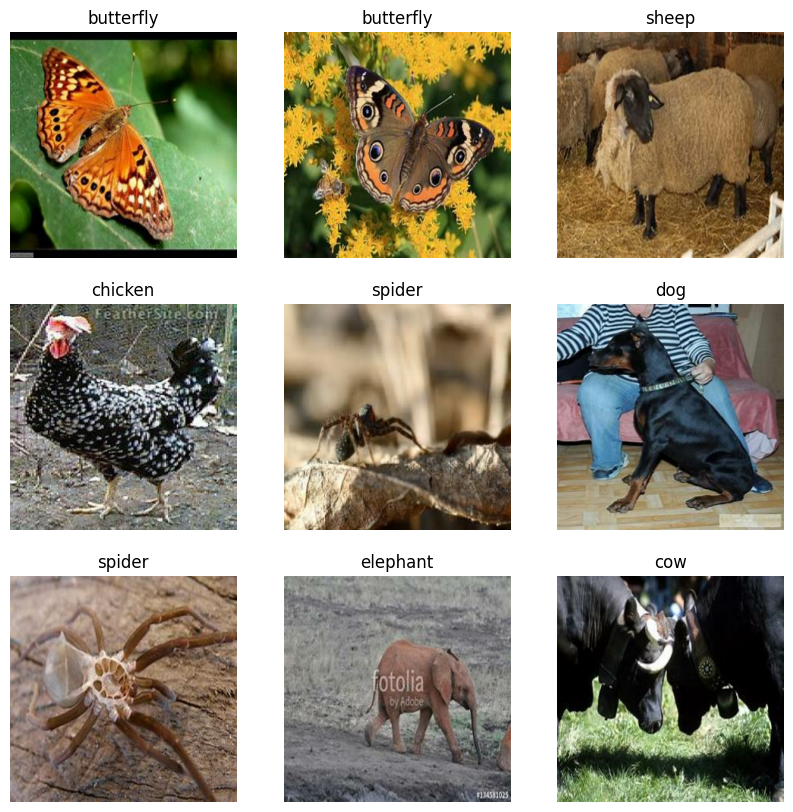

In [ ]:
# Plotting some images and its label.
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We can check that they are all of the same size now, they have been resized.

Finally our data is structured as follows:

Training dataset: 70%
Testing dataset: 15%
Validation dataset: 15%

## 2. ANN Model

Let's first try a simple model fully connected to see what results we get.

Given that using a 299x299 image size in a fully connected neural network would mean training an excessive number of parameters, we'll define a model where firstly we resize the images to 32x32, and then we'll flatten the arrays in order to get our data in (1,3072) format. This is not necessary for convolutional neural networks, but it is mandatory for fully connected neural networks since they expect data to be in vector format.

Our model will use:

- A resizing layer from (299,299) to (32,32).
- A rescaling layer to ensure all pixel values are between 0 and 1.
- A flatten layer to transform the data into a vector of 3072 values (32x32x3).
- A fully connected layer with 2048 neurons using the relu activation function.
- A dropout layer to avoid overfitting with 0.5 probability.
- A fully connected layer with 1024 neurons and relu activation function.
- A dropout layer with a 0.5 probability.
- A fully connected layer that will act as our output layer using the soft max activation function that allows us to output probabilities where the sum of the probabilities for each class will output 1. This layer will have a neuron for each possible output class (10 in our case) and will output a probability for each one; they will sum 1 thanks to soft max.

We are using relu as the activation function because it allows us to learn either lineal and non-linear patterns, it's fast to compute, and it's the current state-of-the-art.

Just to be clear, all neural networks are artificial neural networks. Inside this category, we have:

- Fully connected neural networks, also known as feed-forward neural networks.
- Convolutional neural networks.
- Recurrent Neural Networks.
- Long short term memory networks.
- Autoencoders.
- GANs.

We are using the first type here as a simple model, and we'll move on to convolutional neural networks later on.

Feedforward needs data to be in vectors, while convolutional does not.

It's a typical structure for fully connected neural networks to have its layers in a format where we decrease a fixed % of the number of neurons as we stack layers on.

So for example first layer, 2048 neurons, second layer, 1024, third layer, 512.

This is done in order to learn low and high-level patterns, while the 2048 neurons will learn the most details, and the third layer will learn how to resume them in higher-level features.

We are going to compile and train our model using the following settings:

- Adam optimizer using a learning rate of 0.0001(1e-4).
(https://towardsdatascience.com/the-math-behind-adam-optimizer-c41407efe59b) I feel like it is of the utmost importance to know how each optimizer works and what it does since it's the root of improvement for neural networks.
- 100 epochs training using Early Stopping (stop when the model does not improve) with patience of 10 epochs, we'll monitor the loss in the validation set, and we'll store the weights that gave the model the best result.
- We are going to monitor the accuracy of the training and validation datasets while training.

Finally, our loss function will be categorical cross entropy the one used for multi-classification problems.

In [ ]:
# Model definition using Keras Sequential
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Resizing(32, 32),
        Rescaling(1./255),
        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Compile the model
input_shape = (299, 299, 3)
num_classes = len(class_names)
model = create_model(input_shape, num_classes)
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
# I'm on google colab using this GPU.
!nvidia-smi

Mon Mar 25 17:25:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              42W / 300W |    568MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Train the model
start_time = time.time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[early_stopping])
end_time = time.time()
print(f"Time to train: {end_time - start_time}")
print(model.summary())

Epoch 1/100
287/287 [==============================] - 66s 228ms/step - loss: 2.0553 - accuracy: 0.2682 - val_loss: 1.9782 - val_accuracy: 0.3210
Epoch 2/100
287/287 [==============================] - 47s 160ms/step - loss: 1.9989 - accuracy: 0.2917 - val_loss: 1.9426 - val_accuracy: 0.3106
Epoch 3/100
287/287 [==============================] - 47s 159ms/step - loss: 1.9562 - accuracy: 0.3060 - val_loss: 1.9192 - val_accuracy: 0.3368
Epoch 4/100
287/287 [==============================] - 46s 158ms/step - loss: 1.9276 - accuracy: 0.3246 - val_loss: 1.9065 - val_accuracy: 0.3401
Epoch 5/100
287/287 [==============================] - 46s 157ms/step - loss: 1.9022 - accuracy: 0.3316 - val_loss: 1.8772 - val_accuracy: 0.3450
Epoch 6/100
287/287 [==============================] - 47s 159ms/step - loss: 1.8853 - accuracy: 0.3400 - val_loss: 1.8697 - val_accuracy: 0.3546
Epoch 7/100
287/287 [==============================] - 47s 160ms/step - loss: 1.8623 - accuracy: 0.3506 - val_loss: 1.8482 -

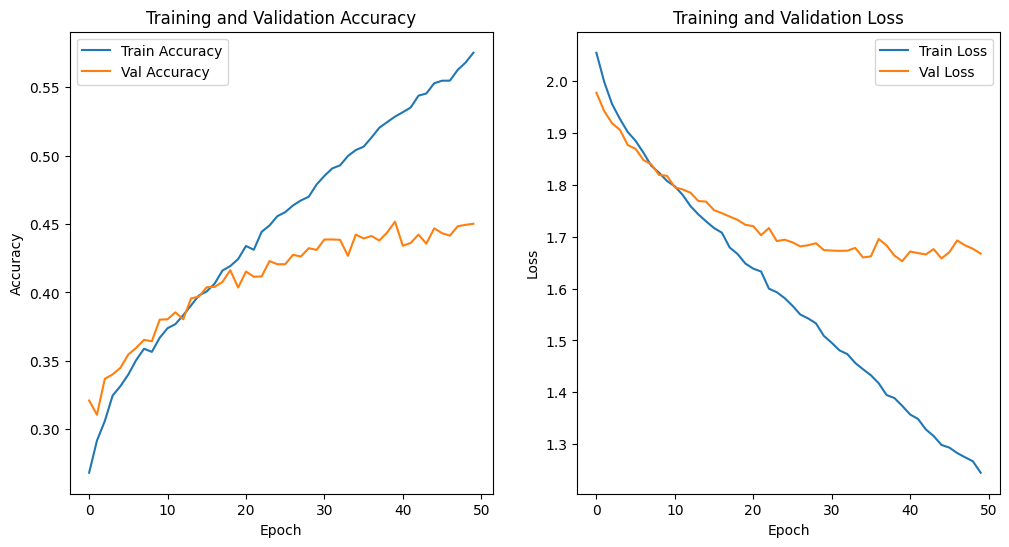

In [ ]:
# Function to represent graphically the progress of accuracy and loss
# for the training and testing datasets, we'll look for overfitting
# looking at these graphs.
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

62/62 [==============================] - 446s 6s/step - loss: 1.7722 - accuracy: 0.3994
Test Loss: 1.7721571922302246
Test Accuracy: 0.39944061636924744


The structure and number of neurons per layer in our model are hyperparameters, meaning that they can be changed and are fixed before training.

The ideal choice is found through hyperparameter tuning, which means that we'll train and test many models with many structures and different numbers of neurons, and we'll choose the one that performs the best. This requires more computing power than you'll be able to get in a Jupyter notebook, and it's out of our scope but can be easily done on cloud platforms.

Our model has 8.401.930 parameters or weights that are trainable; imagine if we had not reduced the images from 299x299 to 32x32. Our training time is about 40 minutes.

The accuracy achieved by the model on the test set is not a good result, 40%, yet taking into account that if we guessed randomly, we would get approximately 10% accuracy, we can easily see that at least it seems the model learned something.

If we take a look at the accuracy and loss curves, we can see a clear overfitting case; the curves of the validation set flatten much earlier than the training ones, meaning our model is learning about the training data, but when it applies what it has learned the validation set, the results are poor, so we could say the model is not grasping a good generalization of the data structure.

Our training process is stopped once we have not bettered the result on the validation set for 10 epochs.

We'll need to construct a model that is able to abstract more patterns and generalize relations better than this one does.

Images are not good stuff to represent as vectors. The reason is that is more important the context in which a pixel is situated than the value of the pixel itself. We need to abstract zones of the images and get to a higher level than studying the pixel values by itself.

So we'll now move on to convolutional layers and maxpoolayers, that will enable us to combine pixel values and combine them into zones, and these zones into even bigger zones.

Convolutional layers are made for data in multidimensional format, and they are best performing there; that's why we'll use them.

Convolution explained: https://en.wikipedia.org/wiki/Convolution
MaxPooling2d: https://keras.io/api/layers/pooling_layers/max_pooling2d/

## 3. Modest convolutional neural network.

Given the lackluster performance of the previous model, we'll try CNN's.

They are specifically good at modeling data in two dimensions, as in our images.

The CNN structure is divided into two blocks:

- Feature extractor: This block generates the different abstraction levels. The deeper those layers are, the better the performance, at least to a certain extent.

- Classifier: This block will use fully connected layers, and the output will be the probability associated with each class.

In our previous model, the feature extractor was very simple; we just took the pixel values.

We will now use convolutional layers to learn better abstractions of the images.

Our feature extractor will use:

- A rescaling input layer, will take images of size (299, 299, 3) and transform the dynamic range of the pixel values to be between 0 and 1 instead of 0 and 255.

- 3 convolutional layers with a kernel (3x3), padding ='same' and activation function relu, we will use 16, 32 and 64 neurons for each layer, going from down to up.

- Each of those layers will be followed by a MaxPooling2D layer, which will feed higher-level data to the next layer.

- A dropout layer with 0.2 probability to avoid overfitting.

As you can see, we have now reversed the pattern used to construct layers previously; instead of 64, 32, 16, we are doing 16, 32, 64.

What we are doing is dedicating a higher number of neurons to the convolutional layers that will deal with the higher-level data.

You can see that we are using a MaxPool2D layer after each convolution. Maxpooling takes a range of pixels determined by the pool_size parameter and resumes that zone into one value, the maximum value of that zone, and does that all along the image for each zone fittable in the pool_size.

This means that after applying this layer, the information we are feeding the next convolutional neural network will be of a higher level, a resumed version of the previous data.

So we are dedicating more neurons to the higher-level information, so our feature extractor is giving more weight to the higher-level information than the raw pixel information, although it also has its weight. Thus, we are able to learn a better generalization.

Our classifier will use:

- A flatten layer to obtain a vector, instead of 2D data, from the resulting information provided by the feature extractor.
- A fully connected layer with 64 neurons and relu as activation function.
- A dropout layer with a 0.5 probability.
- A fully connected output layer, the number of neurons is equal to the number of possible classes (in our case, 10), and the activation function will be soft max to guarantee the sum of output probabilities adds up to 1.

As you can see, we flatten our data now. Can you see why?
The classifier is a fully connected layer, just as was our previous model, so basically we have just used a block of convolutional and max pooling layers to abstract the data, and then we pass that processed data to a fully connected model to classify it.


We are going to compile and train our model with the following settings:

- Adam optimizer using a learning rate of 0.0001(1e-4).
- 100 epochs training using Early Stopping and patience of 10 epochs, we will monitor the validation set loss function, and we will keep the weights of the best model,.
- ReduceLRONPlateau monitoring the loss function of the validation set, using patience of 5 epochs, a factor of 0.2, and a learning rate of 0.000001(1e-6).
- We are going to monitor the accuracy and loss of both datasets during training.

https://keras.io/api/callbacks/reduce_lr_on_plateau/
Reduce LR on Plateau will reduce the learning rate if, in 5 epochs, there has been no progress in the validation loss. This is done in order to try to revive the training when, in 5 epochs, it has not been improving. This may be happening because the learning rate is high enough to simply overpass the minimum point of the loss function, so we try to take a shorter step and see if there is a minimum there that can improve our loss function before stopping our training.

The loss function keeps being the categorical cross entropy, as the nature of the problem has not changed.

In [ ]:
# Model definition
CNN = Sequential([
    # Feature extractor
    Rescaling(1./255, input_shape=(299, 299, 3)),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Classifier
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [ ]:
# Compiling
CNN.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/100
287/287 [==============================] - 53s 164ms/step - loss: 2.1581 - accuracy: 0.2214 - val_loss: 1.9648 - val_accuracy: 0.3299 - lr: 1.0000e-04
Epoch 2/100
287/287 [==============================] - 47s 159ms/step - loss: 2.0062 - accuracy: 0.2868 - val_loss: 1.8592 - val_accuracy: 0.3582 - lr: 1.0000e-04
Epoch 3/100
287/287 [==============================] - 47s 160ms/step - loss: 1.9379 - accuracy: 0.3084 - val_loss: 1.8250 - val_accuracy: 0.3697 - lr: 1.0000e-04
Epoch 4/100
287/287 [==============================] - 48s 163ms/step - loss: 1.8550 - accuracy: 0.3433 - val_loss: 1.7277 - val_accuracy: 0.4150 - lr: 1.0000e-04
Epoch 5/100
287/287 [==============================] - 47s 161ms/step - loss: 1.7794 - accuracy: 0.3634 - val_loss: 1.6726 - val_accuracy: 0.4362 - lr: 1.0000e-04
Epoch 6/100
287/287 [==============================] - 48s 163ms/step - loss: 1.7360 - accuracy: 0.3790 - val_loss: 1.5915 - val_accuracy: 0.4637 - lr: 1.0000e-04
Epoch 7/100
287/287 [=

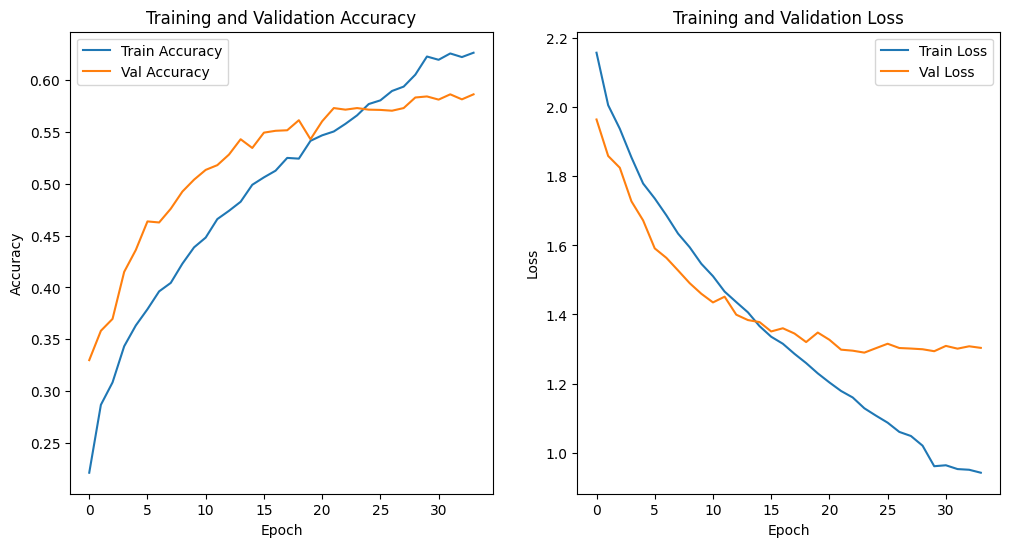

In [ ]:
# Training
start_time = time.time()
history = CNN.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[
                        EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                        ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6, monitor='val_loss', verbose=1)
                    ])
final_time = time.time()
plot_history(history)

In [ ]:
# Evaluate the model against the test dataset
loss, accuracy = CNN.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

62/62 [==============================] - 8s 116ms/step - loss: 1.3669 - accuracy: 0.5477
Pèrdua final sobre les dades de test: 1.3669072389602661
Exactitud final sobre les dades de test: 0.5476735234260559


In [ ]:
total_params = np.sum([np.prod(w.shape) for w in CNN.trainable_weights])
print("Number of trainable parameters:", total_params)
print(f"Training time: {final_time - start_time}")
print(f"The accuracy achieven by the model is {accuracy}")

Nombre de paràmetres a entrenar: 5631722
Temps d'entrenament: 1725.3137938976288
L'accuracy sobre el conjunt de test obtinguda pel model és 0.5476735234260559


We have improved the previous result from 40% to 55%, yet this result does not satisfy us.

Overfitting is also still there; the validation curves flatten much earlier than the training ones, yet it is not as evident as in the previous model.

We are going to introduce a new element that is commonly used in computer vision problems to help the models generalize better. We are going to augmentate our data.

Basically randomly flipping, rotating or zooming our images, so the model focuses on a high level abstraction of what is a spider instead of specific details.

Let's try it.

## 4. Data Augmentation

One way to solve our problems would be to acquire more data. Since this is not always possible, we will augmentate our data by slightly modifying it, so our model focuses more on the patterns than the specific details.

In [ ]:
# Define the augmentation model
augmentation_model = Sequential([
    RandomFlip("horizontal", input_shape=image_size + (3,)),
    RandomRotation(0.1)
])

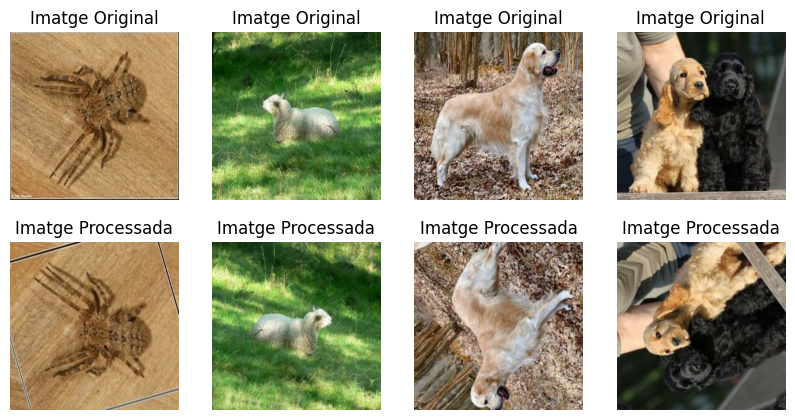

In [ ]:
# Plot some images after augmenting them
import numpy
for images, _ in train_ds.take(1):
    sample_images = images
    break

# Pass the images through the model
output_images = augmentation_model(sample_images, training=True)

# Plot them
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title('Original image')

    plt.subplot(2, 4, i + 5)
    plt.imshow(output_images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title('Processed image')

plt.show()

We will compile and train the model using the follow settings:
- Adam optimizer with a learning rate of 0.001(1e-3), we want to learn faster as the data has been augmentated.
- Train for 100 epochs using EarlyStopping with patience of 10 epochs, monitoring the loss function of the validation set, and keeping the weights of the best model.
- Use ReduceLROnPlateau to monitor the loss function in the validation set, with patience of 5 epochs, a factor of 0.2, and a learning rate of 0.0000001(1e-6).
- Monitoring accuracy and loss during training and validation.

In [ ]:
# Model definition
CNN_augmented = Sequential([
    # Feature extractor
    Rescaling(1./255, input_shape=(299, 299, 3)),
    ## Data augmentation
    RandomFlip("horizontal", input_shape=(299, 299, 3)),
    RandomRotation(0.1),
    ## Convolutional layers
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Classifier
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [ ]:
# Compile the model
CNN_augmented.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/100
287/287 [==============================] - 51s 166ms/step - loss: 2.1218 - accuracy: 0.2430 - val_loss: 1.9463 - val_accuracy: 0.3414 - lr: 0.0010
Epoch 2/100
287/287 [==============================] - 48s 162ms/step - loss: 1.9445 - accuracy: 0.3198 - val_loss: 1.7672 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 3/100
287/287 [==============================] - 48s 162ms/step - loss: 1.8410 - accuracy: 0.3471 - val_loss: 1.6775 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 4/100
287/287 [==============================] - 48s 163ms/step - loss: 1.7985 - accuracy: 0.3597 - val_loss: 1.5716 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 5/100
287/287 [==============================] - 48s 163ms/step - loss: 1.7581 - accuracy: 0.3708 - val_loss: 1.5789 - val_accuracy: 0.4535 - lr: 0.0010
Epoch 6/100
287/287 [==============================] - 48s 165ms/step - loss: 1.7167 - accuracy: 0.3915 - val_loss: 1.5124 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 7/100
287/287 [=========================

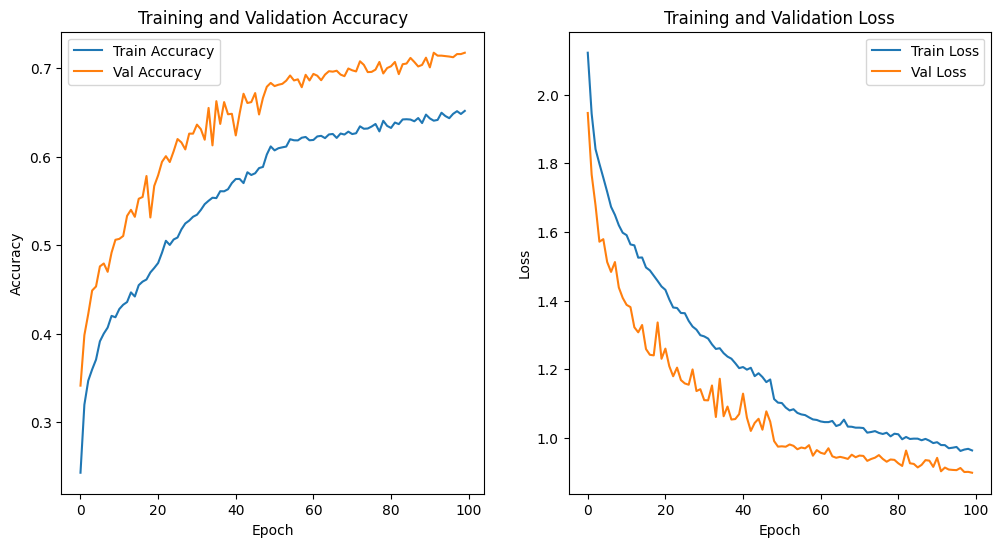

In [ ]:
# Training
start_time = time.time()
history = CNN_augmented.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[
                        EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                        ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6, monitor='val_loss', verbose=1)
                    ])
final_time = time.time()
plot_history(history)

In [ ]:
# Evaluate the model
loss, accuracy = CNN_augmented.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

62/62 [==============================] - 8s 115ms/step - loss: 0.9610 - accuracy: 0.7061
Pèrdua final sobre les dades de test: 0.9610257148742676
Exactitud final sobre les dades de test: 0.7060768008232117


In [ ]:
total_params = np.sum([np.prod(w.shape) for w in CNN_augmented.trainable_weights])
print("Number of trainable parameters:", total_params)
print(f"Training time: {final_time - start_time}")

Nombre de paràmetres a entrenar: 5631722
Temps d'entrenament: 4859.546278715134
L'accuracy sobre el conjunt de test obtinguda pel model és 0.7060768008232117


The number of trainable parameters is 5.631.722, and the training time is about 80 minutes.

The model obtains a 70% accuracy on the test set, a significant improvement. Our accuracy begins to be in the range of acceptable values.

If we take a look at the learning curves, we can see that we have also solved the overfitting problem. Validation curves are better than training ones, and both measures—validation and training—are able to improve at least until a certain limit.

If we wanted to overpass that limit, we could optimize the architecture even more; the way our data is fed can also be improved; we could train the same model for more epochs since no EarlyStopping was triggered; or we could optimize the learning rate.

We'll try to improve our approach later on.

But imagine we needed almost perfect results, and we could not afford to perform infinite amounts of hyperparameter tuning for all the possible tuneable parameters, such as the number of layers, number of neurons, learning rate, alpha, etcetera.

What we would do is pick up the work somebody has already done for us. We are not the only ones who have had this problem, so there are already designed and trained models that would take months or years for us to design and test.

This is called transfer learning.

We are not the only ones that have tried to process images to classify them before, so we'll take a model already trained specifically for image multi-classification called InceptionV3.

There are many; a popular one that comes to mind is ResNet50.
https://es.mathworks.com/help/deeplearning/ref/resnet50.html

Anyway, we'll choose Inception V3.
https://keras.io/api/applications/inceptionv3/

We'll download the already-trained model and apply it to our data.

## 5. Red Inception V3 and transfer learning.

Since it's very expensive to design and train from zero ultra-complex architectures, we'll use an already designed and trained model. We'll test how it performs in our data without any exposure to the actual data, and later we'll let the model have a little bit of exposure to the actual data (fine-tuning) and then test how it does.


### 5.1. Transfer Learning and data augmentation

We'll test the InceptionV3 model on our augmented data used in the last example.
We are going to profit from the already-trained internal weights and see how they perform.

InceptionV3 has been trained on the ImageNet dataset, and we'll adapt it to our task. Luckily, it was trained using 299x299 images—what a coincidence—in the same format as our previous model.

We'll substitute the fully connected layer(classifier) to meet our requirements; we'll use the already trained weights of the rest of the network, but that layer will be redesigned, and its weights will be retrained.

Since the number of parameters we are going to train is huge, we will augmentate even more so we can get a better grasp of the general patterns and trends.

Our augmentation model will now consist of:

- Randomflip, will horizontally flip our images.
- RandomRotation with a factor of 0.1.
- RandomZoom with a factor of 0.1.
- RandomContrast with a factor of 0.1.

Let's pass some images through this block and see how they look.

In [ ]:
# Augmentation model
augmentation_model = Sequential([
    RandomFlip("horizontal", input_shape=(299,299,3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

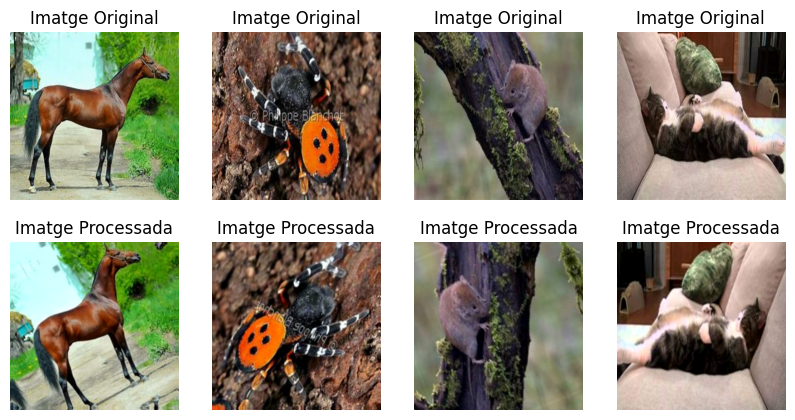

In [ ]:
# Plot some images passed through the model
for images, _ in train_ds.take(1):
    sample_images = images
    break

# Pass images through the model
output_images = augmentation_model(sample_images, training=True)

# Plot the images
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title('Original image')

    plt.subplot(2, 4, i + 5)
    plt.imshow(output_images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title('Preprocessed image')


In order to utilize InceptionV3, we must preprocess our data as it was done during its original training. Keras provides us with a function in order to do so:

inception_v3.preprocess_input

It will scale pixel data in a range of -1 to 1. This function must be applied to data in 0 to 255 format.

Our model will look like:

- Augmentation layer.
- Preprocess input layer. Rescale pixels.
- The InceptionV3 feature extractor has the trained weights frozen.
- A GlobalAveragePooling2d layer to abstract features.

This will be our input processing and feature extraction.

The classifier will look like this:

- A fully connected layer consisting of 1024 neurons using the relu activation function.
- A fully connected layer consisting of 10 neurons using the soft max activation function to output the probabilities for each class.

We are going to compile our model with the following settings:

- RMSprop optimizer with a learning rate of 0.00001 (1e-4), specifically used in InceptionV3.
- Train during 100 epochs using EarlyStopping with patience of 10 epochs and monitoring the loss in the validation set; we'll keep the weights of the best model (classifier ones; the others do not change).
- Use ReduceLROnPlateau to monitor the loss function in the validation set with a factor of 0.2 and a learning rate of 0.0000001(1e-6).
- Monitor the accuracy during training and validation.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Load the training model with frozen weights and without the classificator
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Define our model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda
model = Sequential([
    augmentation_model,
    Lambda(tf.keras.applications.inception_v3.preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=1e-6)

Epoch 1/100
287/287 [==============================] - 63s 188ms/step - loss: 0.3067 - accuracy: 0.9209 - val_loss: 0.1060 - val_accuracy: 0.9712 - lr: 1.0000e-04
Epoch 2/100
287/287 [==============================] - 51s 173ms/step - loss: 0.1542 - accuracy: 0.9537 - val_loss: 0.1041 - val_accuracy: 0.9717 - lr: 1.0000e-04
Epoch 3/100
287/287 [==============================] - 50s 171ms/step - loss: 0.1330 - accuracy: 0.9588 - val_loss: 0.1053 - val_accuracy: 0.9715 - lr: 1.0000e-04
Epoch 4/100
287/287 [==============================] - 50s 170ms/step - loss: 0.1248 - accuracy: 0.9619 - val_loss: 0.0978 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 5/100
287/287 [==============================] - 50s 171ms/step - loss: 0.1109 - accuracy: 0.9661 - val_loss: 0.1088 - val_accuracy: 0.9669 - lr: 1.0000e-04
Epoch 6/100
287/287 [==============================] - 50s 170ms/step - loss: 0.1099 - accuracy: 0.9658 - val_loss: 0.0996 - val_accuracy: 0.9720 - lr: 1.0000e-04
Epoch 7/100
287/287 [=

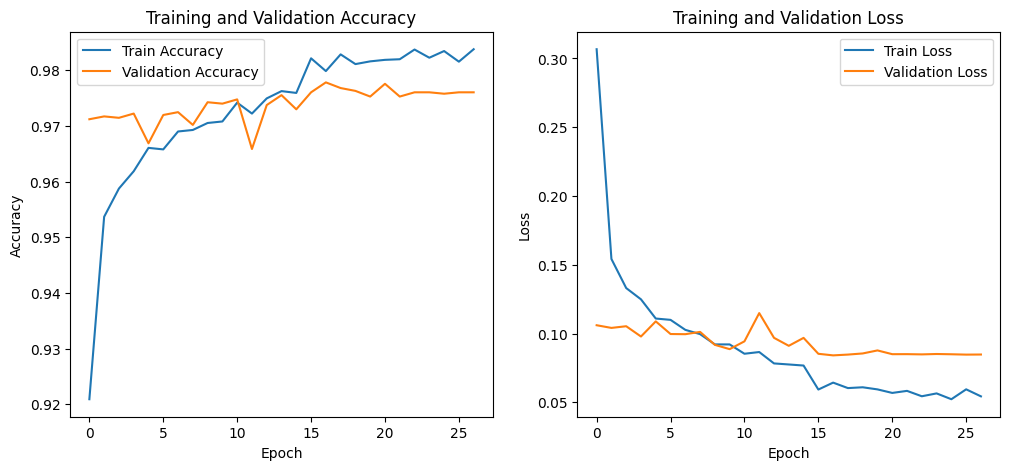

In [ ]:
# Train the model
start_time = time.time()
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])
final_time = time.time()

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

62/62 [==============================] - 10s 153ms/step - loss: 0.0524 - accuracy: 0.9850
Test Loss: 0.0524
Test Accuracy: 0.9850


In [ ]:
total_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
print("Number of trainable weights:", total_params)
print(f"Training time: {final_time - start_time}")

Nombre de paràmetres a entrenar: 2108426
Temps d'entrenament: 1493.575722694397
L'accuracy sobre el conjunt de test obtinguda pel model és 0.9849987030029297


Our trainable weights are less than in the previous neural networks, and you could think, if this is a deeper and more complex neural network, why does it have fewer trainable parameters?

Well, we have frozen the weights; we are only training the classifier, so most of the weights of our model are not trainable.

The training time is 25 minutes.

The model gets a 98.5% accuracy, which is astonishing and nearly unimprovable.

Since the weights have been previously trained, we can see that since the first epoch, we are getting excellent results.

The training curves are almost perfect; they follow similar trends and are nearly identical to each other, so there is no overfitting.

The initial model does provide astonishing results, but it's also able to keep learning and improve performance, which is even better.

The training curve takes slightly better values than the validation curve, which is perfectly fine.

### 5.2. Fine-tuning
We'll use now fine-tuning.

Fine-tuning is basically retraining the whole network using the already-trained weights, exposing them to the training data, optimizing them during a low number of epochs, and using a low learning rate.

So basically, we are giving the feature extractor (where the weights were frozen) the opportunity to learn a bit about the specifics of the actual data.

We'll use the same model.

The compiling settings will vary:

- Adam optimizer with a learning rate of 0.000001(1e-5).
- Training for 10 epochs using Early Stopping with patience of 5 epochs and monitoring the accuracy in the validation set, keeping the weights of the best model.
- ReduceLROnPlateau monitoring the loss function of the validation set and with 3 epochs as patience, factor of 0.2 and a learning rate of 0.00000001(1e-7).
- Monitor the accuracy and loss during training for both datasets.

In [ ]:
# Define the model
fine_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
fine_model.trainable = True
global_model = Sequential([
    augmentation_model,
    Lambda(tf.keras.applications.inception_v3.preprocess_input),
    fine_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
# Compile the model
global_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-7)

Epoch 1/10
287/287 [==============================] - 114s 307ms/step - loss: 0.5719 - accuracy: 0.8680 - val_loss: 0.1004 - val_accuracy: 0.9781 - lr: 1.0000e-05
Epoch 2/10
287/287 [==============================] - 88s 303ms/step - loss: 0.1239 - accuracy: 0.9660 - val_loss: 0.0734 - val_accuracy: 0.9799 - lr: 1.0000e-05
Epoch 3/10
287/287 [==============================] - 88s 303ms/step - loss: 0.0900 - accuracy: 0.9740 - val_loss: 0.0678 - val_accuracy: 0.9811 - lr: 1.0000e-05
Epoch 4/10
287/287 [==============================] - 88s 302ms/step - loss: 0.0715 - accuracy: 0.9801 - val_loss: 0.0647 - val_accuracy: 0.9817 - lr: 1.0000e-05
Epoch 5/10
287/287 [==============================] - 88s 302ms/step - loss: 0.0581 - accuracy: 0.9834 - val_loss: 0.0646 - val_accuracy: 0.9811 - lr: 1.0000e-05
Epoch 6/10
287/287 [==============================] - 87s 301ms/step - loss: 0.0461 - accuracy: 0.9869 - val_loss: 0.0661 - val_accuracy: 0.9811 - lr: 1.0000e-05
Epoch 7/10
287/287 [=======

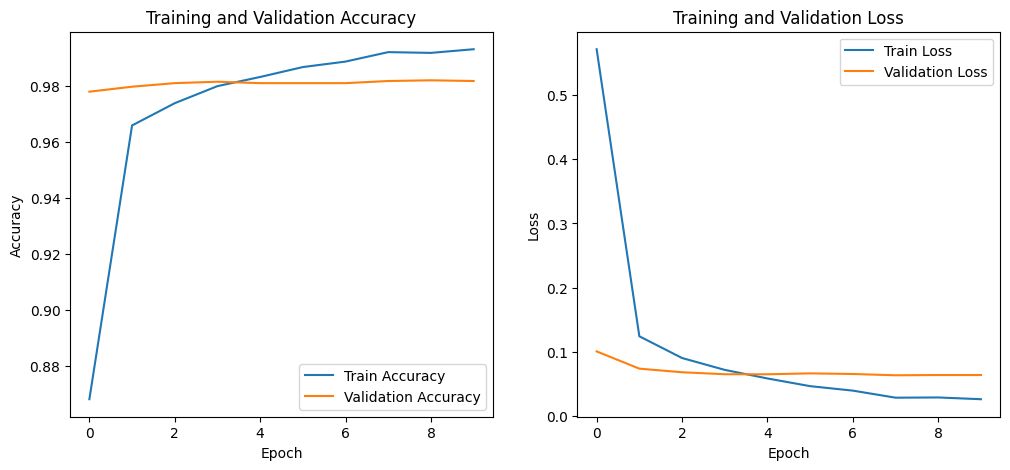

In [ ]:
# Training
start_time = time.time()
history_fine = global_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])
final_time = time.time()

# Plot accuracy and loss curves for both sets.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Evaluate the model
loss, accuracy = global_model.evaluate(test_ds)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

62/62 [==============================] - 236s 3s/step - loss: 0.0407 - accuracy: 0.9868
Test Loss: 0.0407
Test Accuracy: 0.9868


In [ ]:
total_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
print("Number of trainable parameters:", total_params)
print(f"Training time: {final_time - start_time}")

Nombre de paràmetres a entrenar: 2108426
Temps d'entrenament: 902.5978028774261
L'accuracy sobre el conjunt de test obtinguda pel model és 0.9867785573005676


The number of trainable weights is 23.876.778. We can see that it has skyrocketed. That is because we have unfrozen the weights of the feature extractor, and now they are trainable.

It took 16 minutes to train for 10 epochs.

We get a 98.68% accuracy, a 0.18% improvement.

This option has been the one providing the best results.

We could conclude that the combination of transfer learning and fine-tuning might be the best option for complex problems when you don't need or are not able to build an ultra-complex neural network from scratch.

Since it leverages an ultra-complex neural network already trained for a similar problem as yours, this means you don't need to design, find the best combination of hyperparameters, and train  the neural network for long days, but you are able to get its performance, and by exposing this neural network a little bit to your actual data, you optimize the results getting top-tier results with minimum effort.

## 6. Inference and plotting the results

We are going to analyze the results of our model.

- We are going to pass images through our model, visualize them and check the actual and predicted labels.
- We are going to analyze the typical multi-classification metrics such as precision, recall, f1-score and accuracy.
- We are going to analyze the confusion matrix of our results.


In [ ]:
# Predictions and labels
# Get from those the confusion matrix
import scikit_learn
pred = []
labe = []

# For each batch of the test dataset
for images, labels in test_ds:
    # Make a prediction
    predictions = global_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    pred.append(predicted_classes)
    # Get the actual labels
    labe.append(labels)
predictions = [item for sublist in pred for item in sublist]
flattened_labels = [tensor.numpy().flatten().tolist() for tensor in labe]
labels = [item for sublist in flattened_labels for item in sublist]
cm = confusion_matrix(labels, predictions)

1/1 [==============================] - 0s 53ms/step
[[316   1   0   0   0   0   0   0   0   0]
 [  0 246   1   0   2   0   0   0   0   1]
 [  0   0 465   0   0   0   0   0   0   0]
 [  0   0   0 275   2   1   0   2   0   0]
 [  0   3   2   1 721   0   0   2   0   0]
 [  0   0   0   0   1 215   0   1   0   0]
 [  0   0   0   6   1   0 386   0   0   0]
 [  0   0   0   2   4   3   0 264   0   0]
 [ 10   0   0   0   1   0   0   0 718   1]
 [  1   2   0   0   0   0   0   0   1 275]]


In [ ]:
# Classification metrics
report = classification_report(labels,predictions, target_names=test_ds.class_names)
print(report)

              precision    recall  f1-score   support

   butterfly       0.97      1.00      0.98       317
         cat       0.98      0.98      0.98       250
     chicken       0.99      1.00      1.00       465
         cow       0.97      0.98      0.98       280
         dog       0.98      0.99      0.99       729
    elephant       0.98      0.99      0.99       217
       horse       1.00      0.98      0.99       393
       sheep       0.98      0.97      0.97       273
      spider       1.00      0.98      0.99       730
    squirrel       0.99      0.99      0.99       279

    accuracy                           0.99      3933
   macro avg       0.98      0.99      0.99      3933
weighted avg       0.99      0.99      0.99      3933



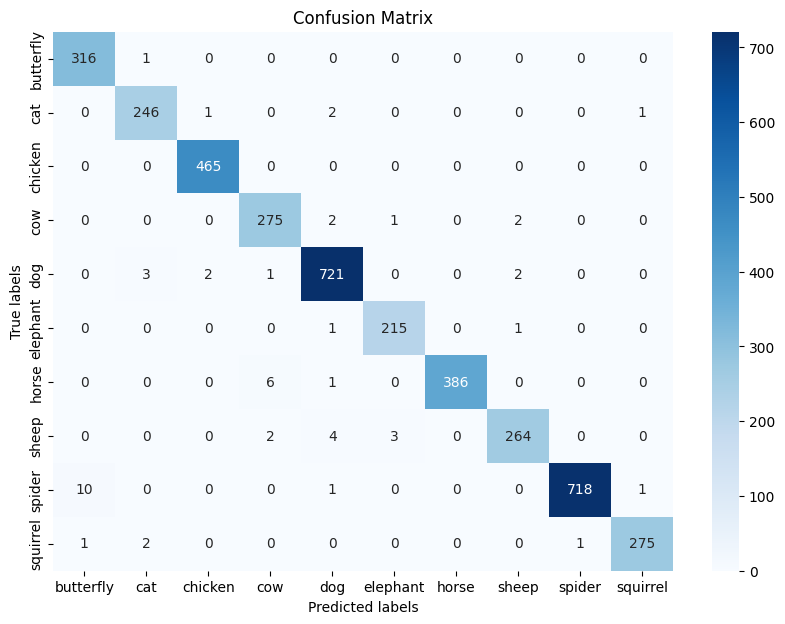

In [ ]:
# Plot the correlation matrix
def plot_confusion_matrix(cm, class_names):
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

  plt.figure(figsize=(10,7))
  sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

plot_confusion_matrix(cm, test_ds.class_names)

The main classification metrics are:

- Precision: TP/(TP+FP) Of all the samples predicted as positive, how many of them were real positives?
- Recall: TP/(TP+FN) Of all the labeled positive samples, how many did we predict?
- F1-Score: Is a combination of precision and recall in order to evaluate the model from a global vision. The best possible value is 1, and the worst is 0.

Usually there is a trade-off between precision and recall, specially if the dataset is skewed to a certain class. As you increase one, you decrease the other.

It's not our case, as our sample is not skewed and our model performs near perfection.

We are evaluating a multi-classification problem; this metrics will take a value for each class, where positive means samples that are labeled as the class and negative all the other samples.

All metrics are nearly unimprovable, and the model is superb at its task.

We can observe in the confusion matrix that the great majority of the samples are situated on the diagonal of the matrix, which indicates that they were classified correctly.

Just to comment on something, we could say that butterfly and spider are the classes that are more difficult to discriminate between them, as it's the value where more samples are mislabeled.

This might be due to the unique structure of the photos, which are more similar between each other than to the other classes.

In a nutshell, the results are nearly unimprovable.


We will now get some random images, print the image, make a prediction and compare it with the actual label using our fine-tuned model.

2/2 [==============================] - 0s 53ms/step


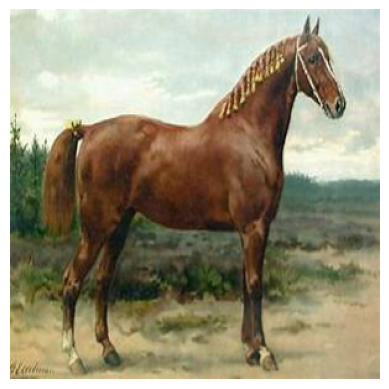

Predicted Class: 6
Actual Label: 6
2/2 [==============================] - 0s 57ms/step


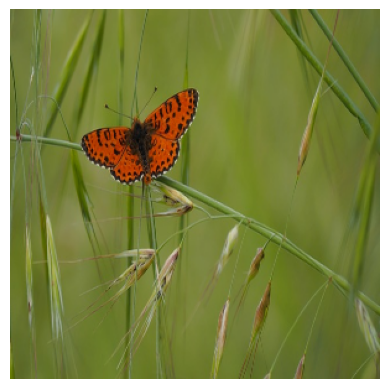

Predicted Class: 0
Actual Label: 0
2/2 [==============================] - 0s 49ms/step


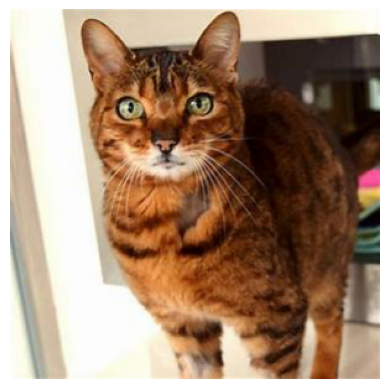

Predicted Class: 1
Actual Label: 1
2/2 [==============================] - 0s 56ms/step


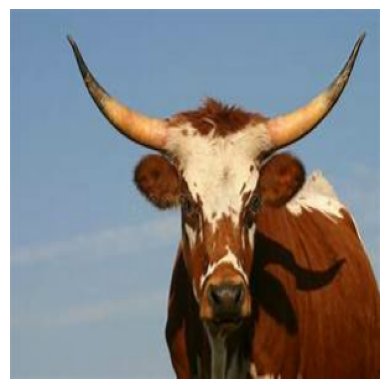

Predicted Class: 3
Actual Label: 3
2/2 [==============================] - 0s 48ms/step


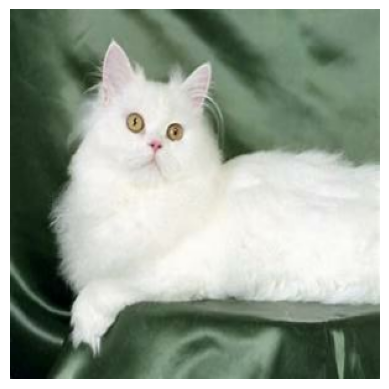

Predicted Class: 1
Actual Label: 1


In [ ]:
# We take 5 random images
for images, labels in test_ds.take(5):
    # Make the prediction
    predictions = global_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot the image
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

    # Print the predicted and actual label
    print("Predicted Class:", predicted_classes[0])
    print("Actual Label:", labels[0].numpy())

All predictions were correct; this was expected since our model has nearly a 99% accuracy of 3933 images, and we are picking just 5.

## 7. Improve the results of our hand-made model

We are going to make changes in our last proposed architecture and the way our data is fed to the model in order to try to improve the results.

In [ ]:
# Define training dataset
# Reduce the batch_size to 32, a common size for computer vision problems.
# We will be able to optimize the loss function the double of teams for each
# epoch.

train_dir = '/content/drive/MyDrive/images/train'
image_size = (299, 299)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1764,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=32
)

# Validation

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1764,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=32
)

# Test

test_dir = '/content/drive/MyDrive/images/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=image_size,
    batch_size=32
)

# Class names

class_names = test_ds.class_names

# We will change the augmentation to the one used for InceptionV3.

augmentation_model = Sequential([
    RandomFlip("horizontal", input_shape=(299,299,3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

# Define the model

my_CNN = Sequential([
    # Feature extractor
    Rescaling(1./255, input_shape=(299, 299, 3)),
	augmentation_model,
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
	# Add a convolutional layer followed by a maxpooling2d
	Conv2D(128, (3,3), padding='same', activation='relu'),
	MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Classifier
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


# Compile the model
my_CNN.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training
start_time = time.time()
myCNN_history = my_CNN.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[
                        EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                        ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6, monitor='val_loss', verbose=1)
                    ])
final_time = time.time()


Found 22253 files belonging to 10 classes.
Using 18328 files for training.
Found 22253 files belonging to 10 classes.
Using 3925 files for validation.
Found 3933 files belonging to 10 classes.
Epoch 1/100
573/573 [==============================] - 1255s 2s/step - loss: 2.0769 - accuracy: 0.2578 - val_loss: 2.0059 - val_accuracy: 0.2983 - lr: 0.0010
Epoch 2/100
573/573 [==============================] - 40s 70ms/step - loss: 1.7799 - accuracy: 0.3748 - val_loss: 1.5719 - val_accuracy: 0.4446 - lr: 0.0010
Epoch 3/100
573/573 [==============================] - 39s 67ms/step - loss: 1.5939 - accuracy: 0.4491 - val_loss: 1.4470 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 4/100
573/573 [==============================] - 40s 70ms/step - loss: 1.4855 - accuracy: 0.4892 - val_loss: 1.2984 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 5/100
573/573 [==============================] - 40s 70ms/step - loss: 1.3775 - accuracy: 0.5275 - val_loss: 1.1697 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 6/100
573/5

In [ ]:
# Evaluate the model
loss, accuracy = my_CNN.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

123/123 [==============================] - 230s 2s/step - loss: 0.7994 - accuracy: 0.7490
Pèrdua final sobre les dades de test: 0.7993993163108826
Exactitud final sobre les dades de test: 0.7490465044975281


We took as a starting point the model proposed in the 4th point, because trying to improve the performance of IncepctionV3 seems a little bit out of scope.

We reduced the batch size to 32, so backpropagation will be done twice as often as for a batch size of 64 at each epoch, so we'll be measuring loss and optimizing double the times we were till now for each epoch.

Furthermore, we add a convolutional layer with 128 neurons following the 64, hoping it will get better abstractions and output them to the classifier. In order to do so, we will also add a maxpooling2d layer following the convolutional one.

The neural network from the 4th point, had an accuracy of 70.6% against the test dataset; our improved neural network has an accuracy of 74.90%, which is quite a good result; we have improved by 4.3%.

The result seems fine; we could try to improve this result, but I feel like it is enough of an example, and the result is quite good. If we wanted better results, if the problem is not extremely complex, it would be better to leverage transfer learning as we did previously in the 4th point.